In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime
from sklearn.model_selection import train_test_split

In [2]:
def extend_vector_with_weekday(hubs,sin,cos,GHI,WS,AT,RA,RD,RI):
    l = []
    for hub in range(len(hubs)):
        h = list(hubs[hub])
        h.extend([sin[hub],cos[hub],GHI[hub],WS[hub],AT[hub],RA[hub],RD[hub],RI[hub]])
        l.append(np.array(h))
    return l

In [37]:
data = pd.read_pickle('DR_Data/pickup_series_6h_10random.pickle')
pickups_out = np.array(data.Hubs)
weekday = False
added_features = 0
if weekday:
    data.Hubs = extend_vector_with_weekday(data.Hubs,data.weekday_sin,data.weekday_cos,data.GHI,data.wind_speed_avg,data.air_temperature, data.rain_accumulation, data.rain_duration, data.rain_intensity)
    added_features = added_features + 8
    
pickups_in = np.array(data.Hubs)

num_zones = pickups_in[0].shape[0] - added_features # -2 from weekdays sin and cos
seq_length = 28
num_intervals = pickups_in.shape[0]-seq_length
num_features = pickups_in[0].shape[0] 

X = np.zeros((num_features, seq_length, num_intervals))
y = np.zeros((num_zones, 1, num_intervals))
for i in range(num_intervals):
    X[:,:,i] = np.array(list(pickups_in[i:i+seq_length])).T
    y[:,:,i] = np.array([pickups_out[i+seq_length]]).T
    
print(X.shape,y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X.transpose(), y.transpose(), test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)
data.head(10)

(10, 28, 1551) (10, 1, 1551)
(1240, 28, 10) (1240, 1, 10)


,index,Hubs,weekday_sin,weekday_cos,month_sin,month_cos,hour_sin,hour_cos,GHI,wind_speed_avg,air_temperature,rain_accumulation,rain_duration,rain_intensity
0,2018-03-04 00:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-0.7818,0.6235,1.0,0.0,0.0,1.0,-0.734450,2.964500,-2.539333,0.000000,0.000000,0.000000
1,2018-03-04 06:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-0.7818,0.6235,1.0,0.0,1.0,0.0,116.378000,3.860167,-2.477000,0.000000,0.000000,0.000000
2,2018-03-04 12:00:00,"[0, 0, 0, 0, 0, 0, 0, 3, 0, 0]",-0.7818,0.6235,1.0,0.0,0.0,-1.0,89.299133,4.086833,-1.904500,0.000000,0.083350,0.000000
3,2018-03-04 18:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-0.7818,0.6235,1.0,0.0,-1.0,-0.0,-0.605567,4.434833,-1.435883,0.000000,0.027783,0.000000
4,2018-03-05 00:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0000,1.0000,1.0,0.0,0.0,1.0,-0.635395,4.933500,-0.756667,0.000000,0.250000,0.000000
5,2018-03-05 06:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0000,1.0000,1.0,0.0,1.0,0.0,46.904333,5.455000,-1.078050,0.000083,1.388733,0.002222
6,2018-03-05 12:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0000,1.0000,1.0,0.0,0.0,-1.0,31.912383,3.754500,-0.637500,0.001472,2.111233,0.084440
7,2018-03-05 18:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0000,1.0000,1.0,0.0,-1.0,-0.0,-0.981850,2.611167,0.234372,0.007027,5.055000,0.418555
8,2018-03-06 00:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.7818,0.6235,1.0,0.0,0.0,1.0,-2.133000,1.115067,0.243338,0.000000,0.000000,0.000000
9,2018-03-06 06:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.7818,0.6235,1.0,0.0,1.0,0.0,290.551667,1.671500,2.494950,0.000000,0.000000,0.000000


In [38]:
#np.array(list(pickups_in[i:i+4]))

In [39]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [40]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#use_cuda =False

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [43]:
rnn_seq_length = seq_length
rnn_input_size = num_features
rnn_hidden_size = 8
rnn_direction = 0

rnn_out_features = rnn_seq_length*rnn_hidden_size*(rnn_direction+1)
features_cat_size = rnn_out_features

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.drop = Dropout(p=0.5)
        self.bn0 = BatchNorm1d(rnn_seq_length)
        
        self.rnn_1 = nn.LSTM(input_size=rnn_input_size,
                            hidden_size=rnn_hidden_size,
                            num_layers=1,
                            bidirectional=(rnn_direction>0))
        
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=num_zones,
                            bias=True)
        
    def forward(self, x):
        features = []
        out = {}
        #x = self.bn0(x)
        
        features_rnn = x.view(rnn_seq_length, -1, rnn_input_size)
        features_rnn,_ = self.rnn_1(features_rnn)
        features_rnn = self.drop(features_rnn)
        
        features_rnn = features_rnn.view(-1, rnn_out_features) #self.rnn_1.hidden_size)
        
        # Append features to the list "features"
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        
        #features_final = self.drop(features_final)
        out['out'] = self.l_out(features_final)
        '''
        x, (h,c) = self.rnn_1(x)
        #x = x.view(-1,self.rnn_1.rnn_hidden_size)
        x = self.l_out(x)
        return x
        '''
        return out['out']

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (bn0): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn_1): LSTM(10, 8)
  (l_out): Linear(in_features=224, out_features=10, bias=True)
)


Epoch 0 	 train loss: 2.4000974638 	 valid loss: 3.1189068995 	 valid acc: 0.7289
Epoch 5 	 train loss: 1.4623536932 	 valid loss: 1.4274547853 	 valid acc: 0.6444
Epoch 10 	 train loss: 1.3679125913 	 valid loss: 1.3676667715 	 valid acc: 0.6480
Epoch 15 	 train loss: 1.3313405943 	 valid loss: 1.3548424118 	 valid acc: 0.6566
Epoch 20 	 train loss: 1.3247952252 	 valid loss: 1.3620128287 	 valid acc: 0.6661
Epoch 25 	 train loss: 1.3331107869 	 valid loss: 1.3516271805 	 valid acc: 0.6618
Epoch 30 	 train loss: 1.3237561893 	 valid loss: 1.3450770284 	 valid acc: 0.6559
Epoch 35 	 train loss: 1.2954409684 	 valid loss: 1.3416555963 	 valid acc: 0.6661
Epoch 40 	 train loss: 1.3132009576 	 valid loss: 1.3338113709 	 valid acc: 0.6595
Epoch 45 	 train loss: 1.2908365285 	 valid loss: 1.3339246700 	 valid acc: 0.6562
Epoch 50 	 train loss: 1.2621465782 	 valid loss: 1.3370915306 	 valid acc: 0.6694
Epoch 55 	 train loss: 1.2756143143 	 valid loss: 1.3311719706 	 valid acc: 0.6566
Epoch 

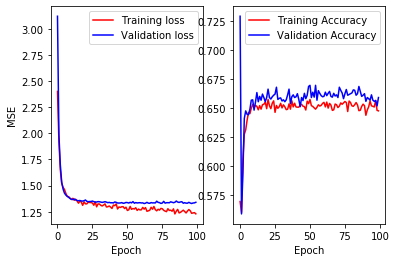

In [44]:
# Hyper-parameters
# setting hyperparameters and gettings epoch sizes
batch_size = 16
num_epochs = 100
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# Define a loss function and optimizer for this problem
criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-3)

def accuracy(ys, ts):
    predictions = torch.round(ys)
    correct_prediction = torch.eq(predictions,ts)
    return torch.mean(correct_prediction.float())

# Track loss
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_training_accs = 0
    epoch_validation_loss = 0
    epoch_validation_accs = 0
    
    net.eval()
    for j in range(num_batches_valid):
        inputs = get_variable(torch.Tensor(X_valid[j * batch_size: (j + 1) * batch_size]))
        targets = get_variable(torch.Tensor(np.squeeze(y_valid[j * batch_size: (j + 1) * batch_size])))
        # Forward pass
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Update loss
        epoch_validation_loss += loss.cpu().detach().numpy()
        epoch_validation_accs += accuracy(outputs, targets)
    
    net.train()
    for j in range(num_batches_train):
        inputs = get_variable(torch.Tensor(X_train[j * batch_size: (j + 1) * batch_size]))
        targets = get_variable(torch.Tensor(np.squeeze(y_train[j * batch_size: (j + 1) * batch_size])))
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss
        epoch_training_loss += loss.cpu().detach().numpy()
        epoch_training_accs += accuracy(outputs,targets)
        
    # Save loss for plot
    train_loss.append(epoch_training_loss/num_batches_train)
    train_accs.append(epoch_training_accs/num_batches_train)
    valid_loss.append(epoch_validation_loss/num_batches_valid)
    valid_accs.append(epoch_validation_accs/num_batches_valid)

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i} \t train loss: {train_loss[-1]:.10f} \t valid loss: {valid_loss[-1]:.10f} \t valid acc: {valid_accs[-1]:.4f}')



# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.subplot(1,2,1)
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('MSE')

plt.subplot(1,2,2)
plt.plot(epoch, train_accs, 'r', label='Training Accuracy')
plt.plot(epoch, valid_accs, 'b', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('')
plt.show()

In [9]:
torch.set_printoptions(sci_mode=False)
outputs

tensor([[     0.4125,      0.0553,      2.4857,      1.4948,      0.2112,
              0.2692,      0.0000,      1.8310,     -0.0255,      0.5142],
        [     0.7217,      0.0051,      0.4113,      0.3200,      0.6248,
              0.1269,      0.0000,      0.4156,     -0.1895,      0.1240],
        [     2.0060,      0.8415,      8.6513,      3.6438,      3.8584,
              1.1735,     -0.0000,      3.4309,      0.0244,      1.7192],
        [     0.3331,      0.0656,      0.0924,     -0.2635,      0.1334,
              0.1439,      0.0000,      0.8401,     -0.0789,      0.0538],
        [     0.1557,      0.1042,     -0.1226,      0.1268,      0.5554,
             -0.0777,      0.0000,     -0.0046,     -0.0923,     -0.4053],
        [    -0.2186,     -0.1326,      0.5742,     -0.1006,     -0.3079,
             -0.0944,      0.0000,      0.4578,      0.0410,      0.1003],
        [     0.9673,      0.0328,      1.1571,      1.0460,      0.8086,
              0.5005,      0.000

In [10]:
targets

tensor([[ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
        [ 4.,  0., 16.,  2.,  3.,  1.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  1.,  0.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  2.],
        [ 0.,  0.,  5.,  0.,  0.,  0.,  0.,  9.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.],
        [ 0.,  0.,  2.,  3.,  1.,  0.,  0.,  4.,  0.,  0.],
        [ 0.,  0.,  5.,  0.,  2.,  0.,  0.,  2.,  0.,  4.],
        [ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.],
        [ 2.,  1.,  1.,  2.,  0.,  3.,  0.,  6.,  0.,  3.],
        [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])

In [11]:
outputs-targets

tensor([[     0.4125,     -0.9447,      1.4857,      1.4948,      0.2112,
              0.2692,      0.0000,      1.8310,     -0.0255,      0.5142],
        [     0.7217,      0.0051,      0.4113,      0.3200,      0.6248,
              0.1269,      0.0000,     -2.5844,     -0.1895,      0.1240],
        [    -1.9940,      0.8415,     -7.3487,      1.6438,      0.8584,
              0.1735,     -0.0000,      2.4309,      0.0244,      1.7192],
        [     0.3331,      0.0656,      0.0924,     -0.2635,      0.1334,
              0.1439,      0.0000,      0.8401,     -0.0789,      0.0538],
        [     0.1557,      0.1042,     -0.1226,      0.1268,     -3.4446,
             -0.0777,      0.0000,     -1.0046,     -0.0923,     -1.4053],
        [    -0.2186,     -0.1326,     -0.4258,     -0.1006,     -0.3079,
             -0.0944,      0.0000,      0.4578,      0.0410,      0.1003],
        [    -1.0327,      0.0328,      0.1571,      1.0460,      0.8086,
             -0.4995,      0.000